# Understand U.S. Yield Curve and Fed Policy Rate

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns

| Symbol       | Full Name (FRED Series)                                                 | Frequency | Unit / Type                      | Description                                                                                                                                      |
| :----------- | :---------------------------------------------------------------------- | :-------- | :------------------------------- | :----------------------------------------------------------------------------------------------------------------------------------------------- |
| **DFF**      | *Effective Federal Funds Rate*                                          | Daily     | Percent (annualized)             | The **overnight interbank lending rate** — the primary tool of U.S. monetary policy. Targeted by the Federal Reserve via open market operations. |
| **DGS2**     | *Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity*  | Daily     | Percent (annualized)             | The **2-year Treasury yield**, often used as a proxy for short-term interest rate expectations and policy stance.                                |
| **DGS10**    | *Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity* | Daily     | Percent (annualized)             | The **10-year Treasury yield**, a benchmark for long-term borrowing costs, mortgage rates, and valuation models.                                 |
| **CPIAUCSL** | *Consumer Price Index for All Urban Consumers: All Items*               | Monthly   | Index (1982-84=100)              | The **headline U.S. inflation** measure; tracks the change in the cost of goods and services purchased by consumers.                             |
| **M2SL**     | *M2 Money Stock*                                                        | Monthly   | Billions of U.S. dollars         | A **broad measure of money supply**, including cash, checking deposits, savings deposits, and retail money market funds.                         |
| **GDPC1**    | *Real Gross Domestic Product (Chained 2017 Dollars)*                    | Quarterly | Billions of chained 2017 dollars | The **inflation-adjusted GDP** — measures overall real economic output of the United States.                                                     |
| **UNRATE**   | *Civilian Unemployment Rate*                                            | Monthly   | Percent                          | The **unemployment rate** — percentage of the labor force that is jobless but actively seeking work.                                             |


| Category                     | Symbols          | Notes                         |
| ---------------------------- | ---------------- | ----------------------------- |
| **Interest Rates**           | DFF, DGS2, DGS10 | Monetary policy + yield curve |
| **Inflation / Prices**       | CPIAUCSL         | Consumer prices               |
| **Money Supply / Liquidity** | M2SL             | Broad liquidity               |
| **Growth / Output**          | GDPC1            | Economic activity             |
| **Labor Market**             | UNRATE           | Slack and cyclical position   |


In [21]:
start_date = "1959-01-01"   # covers all modern macro data
end_date   = None           # defaults to today

symbols = ["DFF", "DGS2", "DGS10", "CPIAUCSL", "M2SL", "GDPC1", "UNRATE"]

# fetch all series explicitly
data_raw = {}
for s in symbols:
    data_raw[s] = web.DataReader(s, "fred", start=start_date, end=end_date)

# merge using outer join (union of dates)
data = pd.concat(data_raw, axis=1, join="outer")

# check date range
print(data.index.min(), "→", data.index.max(), "(", len(data), "raw rows )")
data

1959-01-01 00:00:00 → 2025-10-23 00:00:00 ( 24403 raw rows )


,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE
,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE
DATE,,,,,,,
1959-01-01,2.38,NaN,NaN,29.01,286.6,3352.129,6.0
1959-01-02,2.50,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-03,2.50,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-04,2.50,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-05,2.50,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-10-19,4.11,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-20,4.11,3.46,4.00,NaN,NaN,NaN,NaN


In [22]:
data.shape

(24403, 7)

| Derived Variable         | Formula                         | Meaning                                                                           |
| ------------------------ | ------------------------------- | --------------------------------------------------------------------------------- |
| **Yield Spread (2s10s)** | `DGS10 – DGS2`                  | Measures yield curve slope. Negative (inverted) spreads often precede recessions. |
| **Real Fed Funds Rate**  | `DFF – inflation_yoy`           | Policy stance adjusted for inflation.                                             |
| **Inflation (YoY)**      | `CPIAUCSL.pct_change(12) * 100` | Year-over-year consumer inflation rate.                                           |
| **M2 Growth (YoY)**      | `M2SL.pct_change(12) * 100`     | Year-over-year money supply growth.                                               |
| **Output Growth (YoY)**  | `GDPC1.pct_change(4) * 100`     | Real GDP growth rate (quarterly to annualized).                                   |


#### Resample to monthly frequency

In [23]:
daily = ["DFF", "DGS2", "DGS10"]
monthly = ["CPIAUCSL", "M2SL", "UNRATE"]
quarterly = ["GDPC1"]

data_m = pd.DataFrame(index=pd.date_range(data.index.min(), data.index.max(), freq="ME"))

for col in data.columns.levels[0]:
    s = data[col].dropna()
    if col in daily:
        s = s.resample("ME").mean()
    elif col in quarterly:
        s = s.resample("ME").ffill()
    else:
        s = s.resample("ME").ffill()
    data_m[col] = s

data_m = data_m.dropna(how="all")

print(data_m.shape)
print(data_m.index.min(), "→", data_m.index.max())
data_m

(801, 7)
1959-01-31 00:00:00 → 2025-09-30 00:00:00


,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE
1959-01-31,2.484194,NaN,NaN,29.010,286.6,3352.129,6.0
1959-02-28,2.428571,NaN,NaN,29.000,287.7,3352.129,5.9
1959-03-31,2.803871,NaN,NaN,28.970,289.2,3352.129,5.6
1959-04-30,2.958333,NaN,NaN,28.980,290.1,3427.667,5.2
1959-05-31,2.895161,NaN,NaN,29.040,292.2,3427.667,5.1
...,...,...,...,...,...,...,...
2025-05-31,4.330000,3.920000,4.423810,320.580,21884.6,NaN,4.2
2025-06-30,4.330000,3.889000,4.383500,321.500,22022.1,NaN,4.1
2025-07-31,4.330000,3.882273,4.391818,322.132,22115.8,NaN,4.2
2025-08-31,4.330000,3.703810,4.264762,323.364,22195.4,NaN,4.3


#### Compute derived features

In [24]:
data_m["spread_10y_2y"] = data_m["DGS10"] - data_m["DGS2"]
data_m["inflation_yoy"] = data_m["CPIAUCSL"].pct_change(12) * 100
data_m["m2_growth_yoy"] = data_m["M2SL"].pct_change(12) * 100
data_m["gdp_growth_yoy"] = data_m["GDPC1"].pct_change(12) * 100

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_4039/495526752.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_m["m2_growth_yoy"] = data_m["M2SL"].pct_change(12) * 100
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_4039/495526752.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_m["gdp_growth_yoy"] = data_m["GDPC1"].pct_change(12) * 100


#### Data Coverage & Descriptive Stats

In [25]:
data_m.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
DFF,801.0,4.77,3.60,0.05,2.00,4.65,6.47,19.10
DGS2,592.0,4.98,3.69,0.12,1.68,4.67,7.14,16.46
DGS10,765.0,5.83,2.94,0.62,3.88,5.50,7.54,15.32
CPIAUCSL,801.0,140.94,85.39,28.97,54.60,139.70,214.79,324.37
M2SL,800.0,5595.07,5968.65,286.60,989.40,3398.70,8226.10,22195.40
GDPC1,796.0,11556.31,5862.22,3352.13,6150.13,10236.44,16637.10,23770.98
UNRATE,800.0,5.86,1.69,3.40,4.60,5.60,6.90,14.80
spread_10y_2y,592.0,0.85,0.92,-2.14,0.19,0.80,1.47,2.83
inflation_yoy,789.0,3.75,2.79,-1.96,1.86,3.01,4.66,14.59
m2_growth_yoy,789.0,6.84,3.81,-4.69,4.82,6.61,8.38,26.70


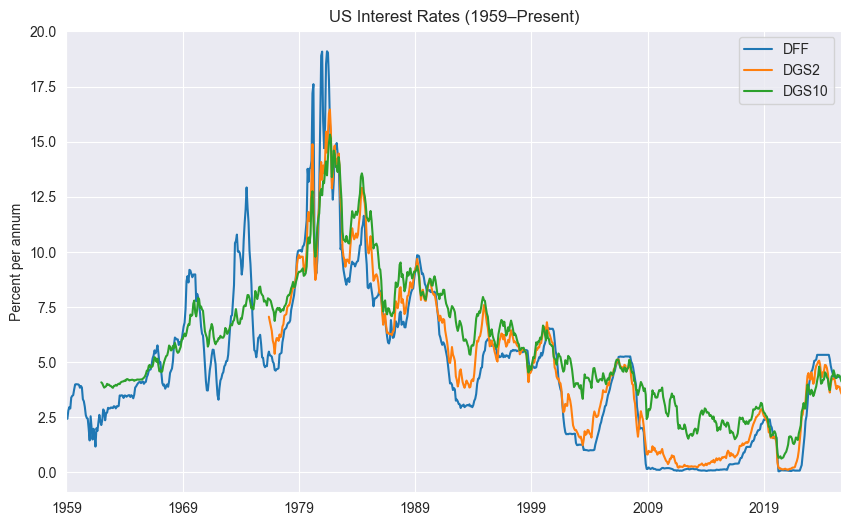

In [26]:
data_m[['DFF', 'DGS2', 'DGS10']].plot(
    figsize=(10, 6), title="US Interest Rates (1959–Present)"
)
plt.ylabel("Percent per annum")
plt.show()

1970s–80s: high inflation → high nominal rates

2008–2021: zero-rate regime

2022–2024: fastest hiking cycle since Volcker era

→ DFF tracks short-term policy, DGS2 roughly follows it, and DGS10 moves more slowly (anchored by inflation expectations).

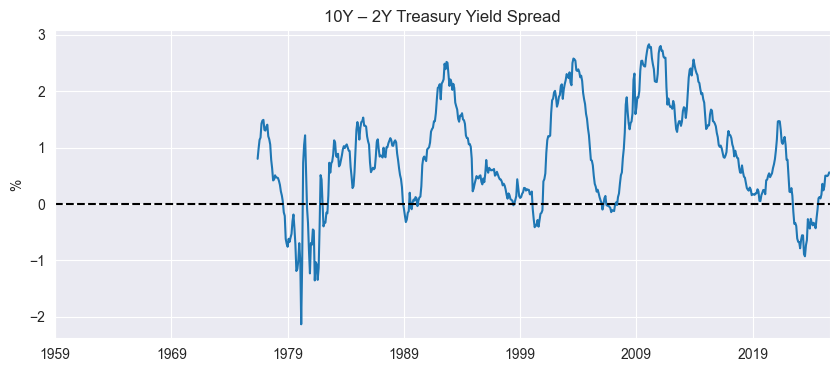

In [27]:
data_m['spread_10y_2y'] = data_m['DGS10'] - data_m['DGS2']
data_m['spread_10y_2y'].plot(
    figsize=(10,4), title="10Y – 2Y Treasury Yield Spread"
)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("%")
plt.show()

💡 Interpret:

Positive → normal yield curve (long-term > short-term)

Negative → inverted curve → often signals upcoming recession

Deep inversions around 1980, 2000, 2006–07, 2019, 2022–2023.

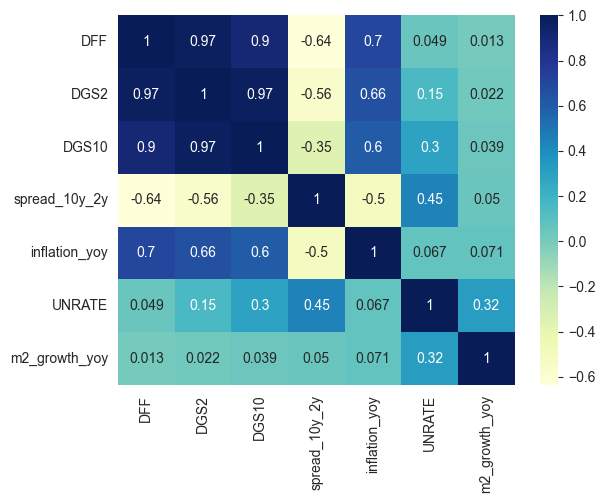

In [28]:
corr = data_m[["DFF", "DGS2", "DGS10", "spread_10y_2y", "inflation_yoy", "UNRATE", "m2_growth_yoy"]].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

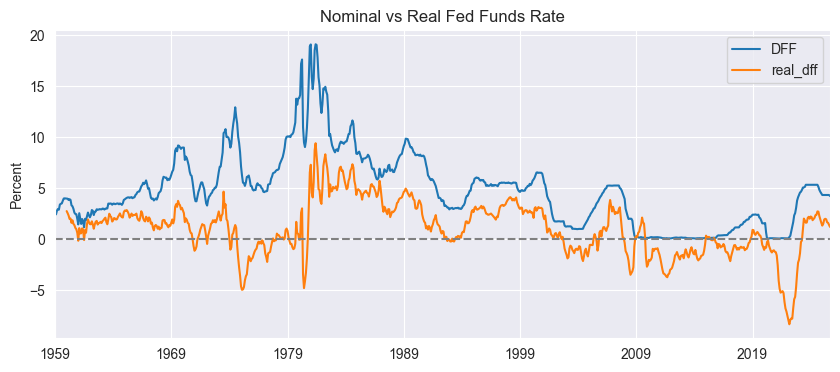

In [29]:
data_m["real_dff"] = data_m["DFF"] - data_m["inflation_yoy"]
data_m[["DFF","real_dff"]].plot(title="Nominal vs Real Fed Funds Rate", figsize=(10,4))
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Percent")
plt.show()

Insight:

Real rate turns negative during loose policy (post-2008, 2020).

Positive real rates → restrictive stance (e.g., 1980s, 2023).

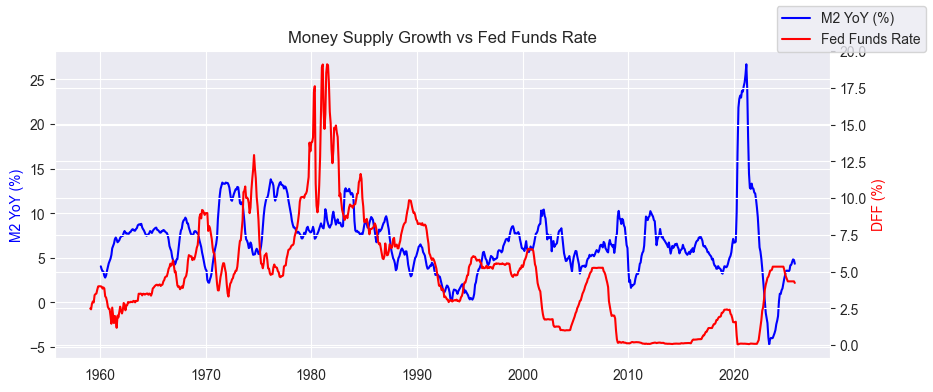

In [30]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(data_m["m2_growth_yoy"], color="blue", label="M2 YoY (%)")
ax2 = ax1.twinx()
ax2.plot(data_m["DFF"], color="red", label="Fed Funds Rate")
ax1.set_title("Money Supply Growth vs Fed Funds Rate")
ax1.set_ylabel("M2 YoY (%)", color="blue")
ax2.set_ylabel("DFF (%)", color="red")
fig.legend(loc="upper right")
plt.show()

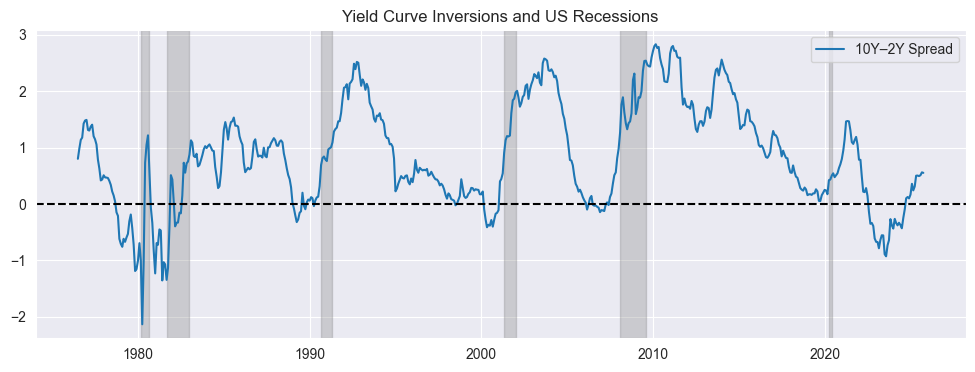

In [31]:
usrec = web.DataReader("USREC", "fred", start=start_date).resample("ME").last()

fig, ax = plt.subplots(figsize=(12,4))
start_ind = data_m["spread_10y_2y"].dropna().index[0]
ax.plot(data_m["spread_10y_2y"].dropna(), label="10Y–2Y Spread")
ax.axhline(0, color='black', linestyle='--')
for i in range(1, len(usrec)):
    if usrec.index[i] < start_ind:
        continue
    if usrec.iloc[i - 1, 0] == 0 and usrec.iloc[i, 0] == 1:
        start = usrec.index[i]
    if usrec.iloc[i - 1, 0] == 1 and usrec.iloc[i, 0] == 0:
        end = usrec.index[i]
        ax.axvspan(start, end, color='gray', alpha=0.3)
ax.set_title("Yield Curve Inversions and US Recessions")
ax.legend()
plt.show()

<Axes: title={'center': 'Monthly log changes in GDP and M2'}>

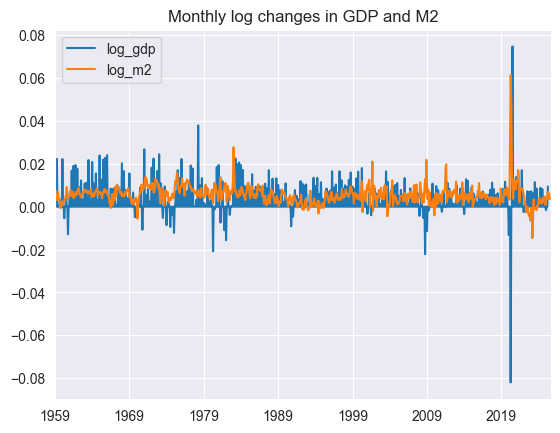

In [32]:
data_m["log_gdp"] = np.log(data_m["GDPC1"])
data_m["log_m2"] = np.log(data_m["M2SL"])
data_m[["log_gdp","log_m2"]].diff().plot(title="Monthly log changes in GDP and M2")


In [33]:
data_m = data_m.join(usrec, how="inner")
data_m

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,gdp_growth_yoy,real_dff,log_gdp,log_m2,USREC
1959-01-31,2.484194,NaN,NaN,29.010,286.6,3352.129,6.0,NaN,NaN,NaN,NaN,NaN,8.117351,5.658088,0
1959-02-28,2.428571,NaN,NaN,29.000,287.7,3352.129,5.9,NaN,NaN,NaN,NaN,NaN,8.117351,5.661918,0
1959-03-31,2.803871,NaN,NaN,28.970,289.2,3352.129,5.6,NaN,NaN,NaN,NaN,NaN,8.117351,5.667118,0
1959-04-30,2.958333,NaN,NaN,28.980,290.1,3427.667,5.2,NaN,NaN,NaN,NaN,NaN,8.139635,5.670226,0
1959-05-31,2.895161,NaN,NaN,29.040,292.2,3427.667,5.1,NaN,NaN,NaN,NaN,NaN,8.139635,5.677438,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,4.330000,3.920000,4.423810,320.580,21884.6,NaN,4.2,0.503810,2.375934,4.223796,2.080467,1.954066,NaN,9.993538,0
2025-06-30,4.330000,3.889000,4.383500,321.500,22022.1,NaN,4.1,0.494500,2.672683,4.540578,2.080467,1.657317,NaN,9.999802,0
2025-07-31,4.330000,3.882273,4.391818,322.132,22115.8,NaN,4.2,0.509545,2.731801,4.823657,1.245417,1.598199,NaN,10.004048,0
2025-08-31,4.330000,3.703810,4.264762,323.364,22195.4,NaN,4.3,0.560952,2.939220,4.767929,1.245417,1.390780,NaN,10.007640,0


In [34]:
data_m.to_csv("../../../data/processed/us_macro_monthly.csv")